# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [14]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

In [10]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [17]:
softmax_loss_naive(W, X_dev, y_dev, 0.0)

(2.3771068222535807,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [22]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.359081
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$  

At the begining, we initialize the W to be a very small value, therefore the result of score of each class would be very small and similar. Then, the softmax loss(-log(s_c/s_all)) equals to -log(1/10). 

In [25]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.947925 analytic: -0.947925, relative error: 1.192190e-08
numerical: -2.189081 analytic: -2.189081, relative error: 4.456470e-10
numerical: -0.301014 analytic: -0.301014, relative error: 2.537914e-07
numerical: 0.733431 analytic: 0.733431, relative error: 1.022083e-08
numerical: -1.961052 analytic: -1.961052, relative error: 5.442302e-09
numerical: 0.176675 analytic: 0.176675, relative error: 1.543649e-07
numerical: 2.202493 analytic: 2.202493, relative error: 5.265188e-08
numerical: -1.559876 analytic: -1.559876, relative error: 3.675696e-08
numerical: -0.212549 analytic: -0.212549, relative error: 2.095660e-08
numerical: 2.522256 analytic: 2.522256, relative error: 1.033001e-08
numerical: -0.763487 analytic: -0.763487, relative error: 3.892959e-08
numerical: 2.213312 analytic: 2.213312, relative error: 6.740648e-09
numerical: -2.430208 analytic: -2.430208, relative error: 3.644246e-10
numerical: -1.069872 analytic: -1.069872, relative error: 3.052979e-08
numerical: -1.25

In [58]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.359081e+00 computed in 0.113766s
vectorized loss: 2.359081e+00 computed in 0.004500s
Loss difference: 0.000000
Gradient difference: 0.000000


In [60]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

cro_val_step = 5
lr_upper_bound = 1e-5
lr_lower_bound = 1e-7
learning_rates = np.arange(lr_lower_bound, lr_upper_bound, (lr_upper_bound - lr_lower_bound)/cro_val_step).tolist()
reg_upper_bound = 5e4
reg_lower_bound = 2.5e4
regularization_strengths = np.arange(reg_lower_bound, reg_upper_bound, (reg_upper_bound - reg_lower_bound)/cro_val_step).tolist()


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
count = 0
all_count = len(learning_rates) * len(regularization_strengths)
for lr in learning_rates:
    for reg in regularization_strengths:
        
        print('lr {0} reg {1}, start!'.format(lr, reg))
        tic = time.time()
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=True)
        train_acc = np.mean(y_train == softmax.predict(X_train))
        val_acc = np.mean(y_val == softmax.predict(X_val))
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax
            
        count += 1
        toc = time.time()
        print('%d/%ddone!\n%fs remain.' % (count, all_count, (all_count - count) * (toc - tic)))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1e-07 reg 25000.0, start!
iteration 0 / 1500: loss 776.316926
iteration 100 / 1500: loss 285.050727
iteration 200 / 1500: loss 105.477387
iteration 300 / 1500: loss 39.940401
iteration 400 / 1500: loss 15.961468
iteration 500 / 1500: loss 7.150509
iteration 600 / 1500: loss 3.940118
iteration 700 / 1500: loss 2.718725
iteration 800 / 1500: loss 2.275899
iteration 900 / 1500: loss 2.135959
iteration 1000 / 1500: loss 2.126432
iteration 1100 / 1500: loss 2.140748
iteration 1200 / 1500: loss 2.072708
iteration 1300 / 1500: loss 2.072617
iteration 1400 / 1500: loss 2.114840
1/25done!
80.443943s remain.
lr 1e-07 reg 30000.0, start!
iteration 0 / 1500: loss 938.605099
iteration 100 / 1500: loss 281.921137
iteration 200 / 1500: loss 85.745109
iteration 300 / 1500: loss 27.169283
iteration 400 / 1500: loss 9.538541
iteration 500 / 1500: loss 4.371581
iteration 600 / 1500: loss 2.757383
iteration 700 / 1500: loss 2.315075
iteration 800 / 1500: loss 2.205484
iteration 900 / 1500: loss 2.12604

iteration 800 / 1500: loss 2.242903
iteration 900 / 1500: loss 2.322402
iteration 1000 / 1500: loss 2.319727
iteration 1100 / 1500: loss 2.338867
iteration 1200 / 1500: loss 2.232554
iteration 1300 / 1500: loss 2.248457
iteration 1400 / 1500: loss 2.532469
14/25done!
38.849604s remain.
lr 4.06e-06 reg 45000.0, start!
iteration 0 / 1500: loss 1389.050649
iteration 100 / 1500: loss 2.285117
iteration 200 / 1500: loss 2.587088
iteration 300 / 1500: loss 2.375239
iteration 400 / 1500: loss 2.304006
iteration 500 / 1500: loss 2.163755
iteration 600 / 1500: loss 3.146657
iteration 700 / 1500: loss 2.344058
iteration 800 / 1500: loss 2.261891
iteration 900 / 1500: loss 2.319532
iteration 1000 / 1500: loss 2.449575
iteration 1100 / 1500: loss 2.328624
iteration 1200 / 1500: loss 2.456458
iteration 1300 / 1500: loss 2.348723
iteration 1400 / 1500: loss 2.224781
15/25done!
32.233241s remain.
lr 6.040000000000001e-06 reg 25000.0, start!
iteration 0 / 1500: loss 771.709435
iteration 100 / 1500: lo

In [61]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.338000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$
True! (But there are still some possibilities that svm loss would change.)

$\color{blue}{\textit Your Explanation:}$

Since the softmax loss $-log(\frac{e^{s_c}}{\sum_j{e^{s_j}}})$ computates the loss based on softmax value, the result will definitely change. The softmax value is the probability of all classes. For the new training data, the softmax value of it would be something like [0.01, 0.81,0.02,0.11,0.05], therefore the loss will change. 
However, svm loss $max(0, s_i - s_c + 1)$ could be 0 if $ s_c > s_i + 1 $ which would happen because we have already trained many data so the $s_c$ are more likely to be large. <u>But I think there are some possiblities that the svm loss would change if this new training data is not similar with the trained data.</u>


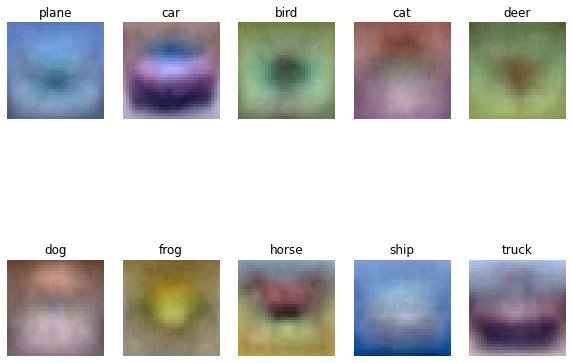

In [62]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])